In [41]:
import time
import subprocess
import matplotlib.pyplot as plt
import psutil
import os
import re
import threading
import csv
import signal
import numpy as np
import math
import fcntl
import select

In [42]:
models = ["DT_generator","DT_generator_CPS","IDT_generator","subroutine_generator"]

In [43]:
for model in models:
    subprocess.run(["clang++", "-std=c++20", model+".cpp", "-o", model])


In [44]:
directory = './grammars'
files = os.listdir(directory)
print(files)

['math.json', 'recursive.json', 'simple_grammar.json', 'css.json', 'html.json']


In [45]:
depth = [1,2,4,8,16,32,64,128,256,512,1024,2048]

In [46]:
result = {}
timeout = 5  # Timeout for each test in seconds

def set_non_blocking(fd):
    """Set the file descriptor to non-blocking mode."""
    flags = fcntl.fcntl(fd, fcntl.F_GETFL)
    fcntl.fcntl(fd, fcntl.F_SETFL, flags | os.O_NONBLOCK)

for i in range(len(models)):
    program_name = models[i]
    result[program_name] = {}
    for j in range(len(files)):
        file_name = files[j]
        result[program_name][file_name] = {}
        for k in range(len(depth)):
            depth_value = depth[k]
            current_file_name = f"{program_name}_{depth_value}_{file_name}.fth"
            
            # Pre-compilation step
            pre_compile = subprocess.run(
                ["./"+program_name, "-p", f"./grammars/{file_name}", "-d", str(depth_value), "-o", current_file_name,"--endless"],
                check=True
            )
            
            # Start the subprocess
            process = subprocess.Popen(
                ["gforth-fast", current_file_name, "-e", "bye"],
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                text=True
            )

            # Set stdout and stderr to non-blocking mode
            set_non_blocking(process.stdout.fileno())
            set_non_blocking(process.stderr.fileno())

            start_time = time.time()
            total_bytes = 0
            
            try:
                while time.time() - start_time < timeout:
                    # Use select to check for readable output
                    ready, _, _ = select.select([process.stdout, process.stderr], [], [], 1)
                    for stream in ready:
                        line = stream.readline()
                        if line:
                            total_bytes += len(line.encode('utf-8'))

            except Exception as e:
                print(f"Error occurs: {e}")
            finally:
                # Immediately kill the process if still running
                process.kill()
                process.wait()

            print(f"total_bytes: {total_bytes}")
            output_speed = total_bytes / timeout
            result[program_name][file_name][depth_value] = output_speed
            print(f"{program_name} {file_name} {depth_value} {output_speed:.2f} Bytes/s")

print(result)

Code written to file successfully.
total_bytes: 18903340
DT_generator math.json 1 3780668.00 Bytes/s
Code written to file successfully.
total_bytes: 22643806
DT_generator math.json 2 4528761.20 Bytes/s
Code written to file successfully.
total_bytes: 35502030
DT_generator math.json 4 7100406.00 Bytes/s
Code written to file successfully.
total_bytes: 31960476
DT_generator math.json 8 6392095.20 Bytes/s
Code written to file successfully.
total_bytes: 28418101
DT_generator math.json 16 5683620.20 Bytes/s
Code written to file successfully.
total_bytes: 28238706
DT_generator math.json 32 5647741.20 Bytes/s
Code written to file successfully.
total_bytes: 28196864
DT_generator math.json 64 5639372.80 Bytes/s
Code written to file successfully.
total_bytes: 28196864
DT_generator math.json 128 5639372.80 Bytes/s
Code written to file successfully.
total_bytes: 28114944
DT_generator math.json 256 5622988.80 Bytes/s
Code written to file successfully.
total_bytes: 28246016
DT_generator math.json 512 

In [47]:
## convert the result in MB/s
for i in range(len(models)):
    program_name = models[i]
    for j in range(len(files)):
        file_name = files[j]
        for k in range(len(depth)):
            depth_value = depth[k]
            if program_name in result and file_name in result[program_name] and depth_value in result[program_name][file_name]:
                result[program_name][file_name][depth_value] = result[program_name][file_name][depth_value] / 1024 / 1024


In [48]:
# Save the result in a csv file
with open('results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Program', 'File', 'Depth', 'Average Throughput Rate (MB/s)'])
    for program_name, files_dict in result.items():
        for file_name, depths_dict in files_dict.items():
            for depth_value, avg_throughput_rate in depths_dict.items():
                writer.writerow([program_name, file_name, depth_value, avg_throughput_rate])

print("Results have been written to results.csv")


Results have been written to results.csv


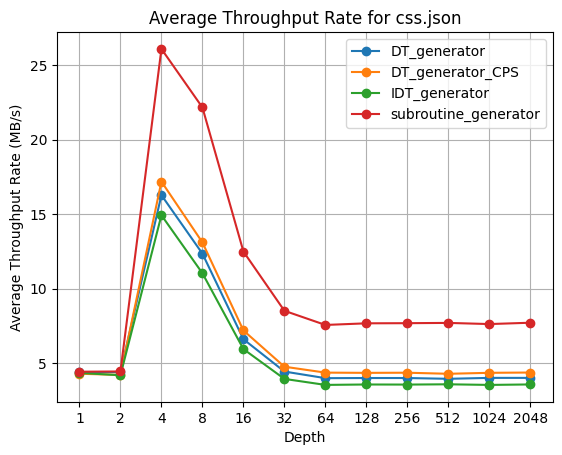

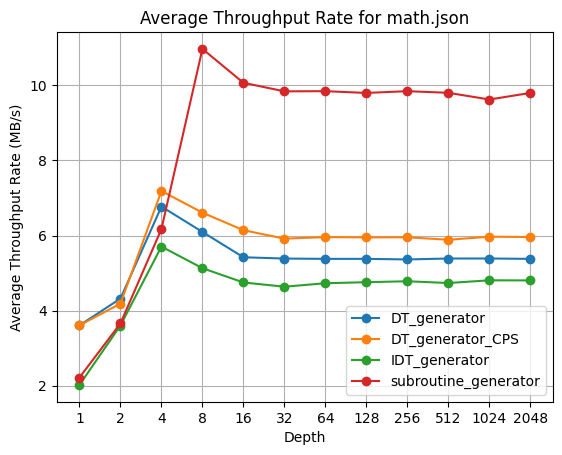

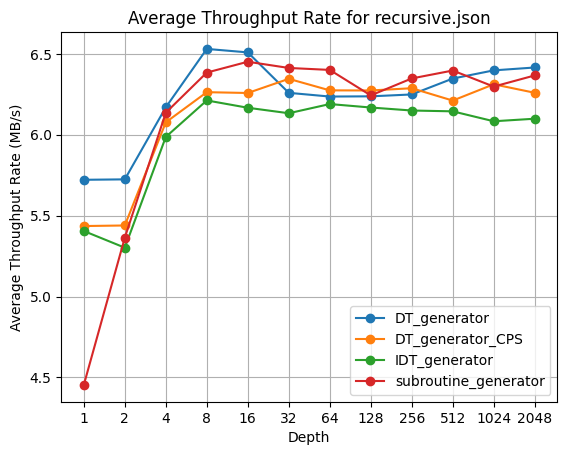

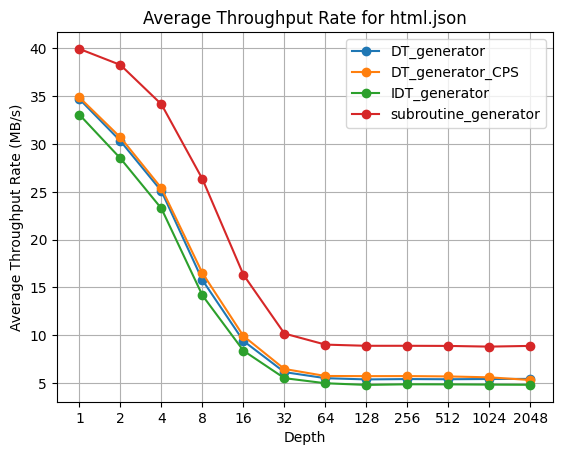

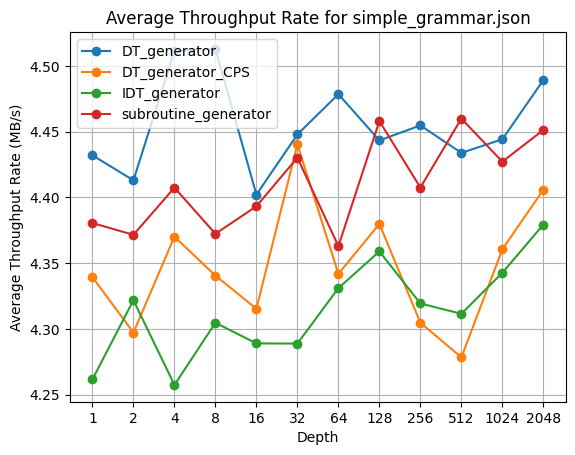

In [50]:
csv_filename = 'results.csv'

results = {}

with open(csv_filename, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        program_name = row['Program']
        file_name = row['File']
        dp = int(row['Depth'])
        avg_throughput_rate = float(row['Average Throughput Rate (MB/s)'])

        if program_name not in results:
            results[program_name] = {}
        if file_name not in results[program_name]:
            results[program_name][file_name] = {}

        if dp not in results[program_name][file_name]:
            results[program_name][file_name][dp] = []
        
        results[program_name][file_name][dp].append(avg_throughput_rate)

for file_name in {file_name for program_data in results.values() for file_name in program_data.keys()}:
    plt.figure()
    for program_name in results.keys():
        if file_name in results[program_name]:
            depths = sorted(results[program_name][file_name].keys())
            rates = [results[program_name][file_name][d] for d in depths]
            plt.plot([math.log(x,2) for x in depths], rates, marker='o', label=program_name)
    
    plt.xlabel('Depth')
    plt.ylabel('Average Throughput Rate (MB/s)')
    plt.title(f'Average Throughput Rate for {file_name}')
    plt.legend()
    plt.grid(True)

    plt.xticks([math.log(x,2) for x in depths], [str(d) for d in depths])

    plt.savefig(f"{file_name}_throughput.png")
    plt.show()

In [49]:

import glob

current_directory = os.getcwd()
files = glob.glob(os.path.join(current_directory, '*.fth'))

for file in files:
    try:
        os.remove(file)
        print(f'Deleted: {file}')
    except Exception as e:
        print(f'Error deleting {file}: {e}')


Deleted: /Users/apple/gForthVM/DT_generator_CPS_1024_html.json.fth
Deleted: /Users/apple/gForthVM/subroutine_generator_8_html.json.fth
Deleted: /Users/apple/gForthVM/DT_generator_1024_math.json.fth
Deleted: /Users/apple/gForthVM/subroutine_generator_2_math.json.fth
Deleted: /Users/apple/gForthVM/DT_generator_CPS_64_simple_grammar.json.fth
Deleted: /Users/apple/gForthVM/IDT_generator_1_css.json.fth
Deleted: /Users/apple/gForthVM/DT_generator_1_css.json.fth
Deleted: /Users/apple/gForthVM/DT_generator_16_simple_grammar.json.fth
Deleted: /Users/apple/gForthVM/DT_generator_CPS_1_css.json.fth
Deleted: /Users/apple/gForthVM/subroutine_generator_128_css.json.fth
Deleted: /Users/apple/gForthVM/DT_generator_2048_recursive.json.fth
Deleted: /Users/apple/gForthVM/simp.fth
Deleted: /Users/apple/gForthVM/IDT_generator_128_math.json.fth
Deleted: /Users/apple/gForthVM/DT_generator_CPS_16_css.json.fth
Deleted: /Users/apple/gForthVM/subroutine_generator_128_math.json.fth
Deleted: /Users/apple/gForthVM/I